# Spaced

``Spaced`` is a Python library which provides adaptive cognitive training schedules.

``Spaced`` suggests training dates which gradually become more dispersed over time.  If you train in such a way, you end up remembering more than you would if you put the same amount of attention into your studies over a short duration (say, in an intense cram session).  

 This [spacing effect](https://en.wikipedia.org/wiki/Spacing_effect) was discovered by the German psychologist [Hermann Ebbinghaus](https://en.wikipedia.org/wiki/Hermann_Ebbinghaus) in the 1880s.

The algorithm used by ``spaced``, is a mash-up of a spaced-learning-algorithm with a [simple control system](https://en.wikipedia.org/wiki/PID_controller).  It provides training date suggestions, which become less frequent over time while being responsive to what a student actually does.

Let's use the library to suggest a training schedule over 43 days:

In [1]:
from datetime import datetime
from spaced_repetition import SpaceRepetitionReference

start_time = datetime.now()
range_in_days = 43

hr = SpaceRepetitionReference(range=range_in_days, epoch=start_time)
%timeit SpaceRepetitionReference(range=range_in_days, epoch=start_time)
hr.schedule()

29.2 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


[datetime.datetime(2018, 11, 30, 10, 25, 55, 999162),
 datetime.datetime(2018, 11, 30, 21, 26, 48, 784163),
 datetime.datetime(2018, 12, 1, 11, 58, 3, 425670),
 datetime.datetime(2018, 12, 2, 8, 56, 47, 931223),
 datetime.datetime(2018, 12, 3, 16, 9, 55, 203675),
 datetime.datetime(2018, 12, 5, 15, 9, 2, 339830),
 datetime.datetime(2018, 12, 8, 14, 11, 28, 241948),
 datetime.datetime(2018, 12, 13, 1, 48, 25, 858589),
 datetime.datetime(2018, 12, 19, 20, 57, 31, 714812),
 datetime.datetime(2018, 12, 30, 4, 23, 12, 132452)]

## Forgetting and Plasticity Curves
To see where the above dates are coming from, let's draw the forgetting curves for the idea we are trying to remember.

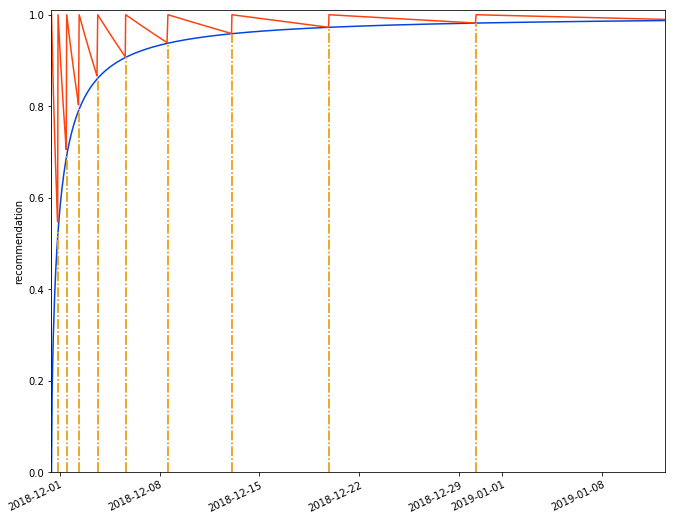

In [4]:
hdl, _  = hr.plot_graph()

In [5]:
# close the plot when you are done save memory
hdl.close()


The graph's x-axis represents time while the y-axis represents the amount a student can remember about the thing they are trying to learn.  The student has perfectly remembered an idea if its score is one and they have utterly forgotten an idea if its score is zero.

The red stickleback looking graph represents how a students recollection ability will rise and fall as a function of training events and the passage of time from a given training event.  At first, a student forgets something quickly, but as they train on an idea, that idea will fade slower from their memory.  The sudden rise of this red line represents a moment when the student studies.  There is an assumption that they will review an idea long enough that their immediate recollection of that idea will be perfect before they stop thinking about it.

The blue line maps to plasticity, or how fast an idea can be mapped into a mind as a function over time.  This plasticity curve can be thought of as a  training goal.

The training events occur where the forgetting curves of the stickleback approach the plasticity line.  At each intersection of the forgetting curve and the plasticity curve, orange lines are projected downward to the x-axis to provide the suggested times of study.  Collectively, these times are called the schedule.


## Student Feedback
Even if a student dedicates themselves to learning an idea, they still have other priorities to attend too.  It is doubtful that they will be able to train when we want them to.  

Furthermore, the forgetting and plasticity curves used to generate the schedule are unknowable, they are just guesses at what is likely.  To demand someone change their life to meet a plan based upon such fiction is a little perverse.

Let's suppose that our student has been training, even if it isn't precisely when our model requires them to train.   We ask them to rate how well they remember something just before they review it, and then we ask them to report on this result and the time when their review occurred.

Let's put all of this information together and put it into a function called feedback:

In [2]:
def feedback():
  '''
  Here are 10 actual training moments with corresponding results.
  '''
  offset_in_days_from_introduction_to_idea = [
          0,
          0.80640320160080037,
          1.7523761880940469,
          3.0240120060030016,
          4.8074037018509257,
          7.3351675837918959,
          10.932966483241621,
          16.004002001000501,
          23.029014507253628,
          29.029014507253628
        ]
  # how well they could remember the thing prior to training on it
  # so as to get perfect recollection.
  results = [
          0.40,
          0.44646101201172317,
          0.64510969552772512-0.1,
          0.76106659335521121-0.2,
          0.83741905134093808-0.3,
          0.89000147547559727,
          1.00000000000000000,
          0.99994393927347419,
          0.99929261332375605,
          1.00
          ]
  return [offset_in_days_from_introduction_to_idea, results]

feedback()


[[0,
  0.8064032016008004,
  1.752376188094047,
  3.0240120060030016,
  4.807403701850926,
  7.335167583791896,
  10.932966483241621,
  16.0040020010005,
  23.029014507253628,
  29.029014507253628],
 [0.4,
  0.44646101201172317,
  0.5451096955277251,
  0.5610665933552113,
  0.537419051340938,
  0.8900014754755973,
  1.0,
  0.9999439392734741,
  0.9992926133237561,
  1.0]]

We see that the student did well: on the 10th day after which they were introduced to an idea, they could remember it perfectly even though they hadn't looked at it for about three days.

## Spaced adapts to the student using a control system

The spaced library wants to be adaptive to what happens in a student's life.  If a student goes on vacation and ignores their studies for a while, then a new schedule should be provided upon their return which suggests that they look at a thing more often than they would have had they not ignored it while on their break.

To do this, spaced uses a control system.  A control system needs a reference or a goal about how we would like things to happen.  The graph that we have been describing up until this point will serve as our goal.  A control system requires some feedback or information on how well it did in meeting its goals.  The difference between the goal and the feedback represents a control system's error, or how bad it did in trying to achieve its goal.  This error is used as the input to the control system's plant, which will exert some sort of will, expressed as an action upon the outside world to reduce the error it is experiencing.

If a student where to go on vacation and forget about their studies, the control system would experience a significant error when the student came back and activated it again.  This would cause the control system to exert its will by suggesting a very aggressive schedule for the student.  If the student complied and got results (maybe because they are feeling good and relaxed from their vacation), the control system would exert less control and expand out the schedule for future training events.  Let's take a look at how spaced does this over time.

An error can be made in the other direction too.  If a student studies too much and improves faster than expected, the spaced algorithm with relax their learning schedule.

Consider the first couple of training examples:

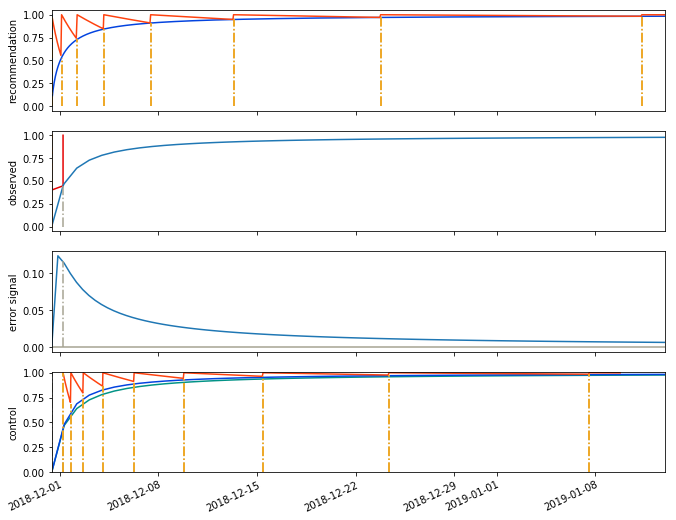

In [3]:
from spaced_repetition import SpaceRepetitionReference
from spaced_repetition import SpaceRepetitionFeedback
from spaced_repetition import SpaceRepetitionController
import numpy as np
from datetime import datetime
from datetime import timedelta

start_time    = datetime.now()
x, y          = feedback()
range_in_days = x[-1] * 1.5

# setting up our reference (goals)
hr = SpaceRepetitionReference(plasticity=1.4,   # for slower learning, pick lower numbers
                              fdecaytau=0.87,   # ability to improve after a lesson, lower is better
                              fdecay0=0.9,      # seen it before? then pick lower numbers
                              epoch=start_time,
                              range=range_in_days,
)

# what actually happened (feedback), range and epoch determined from hr
hf = SpaceRepetitionFeedback(x[0:2], y, range=range_in_days)

# giving our control system the reference and the feedback
hctrl = SpaceRepetitionController(reference=hr, feedback=hf)
hdl, _ = hctrl.plot_graphs()



The recommended graph is the reference feed to the control system; the observed graph is the part of our feedback that we feed to the control system.  The difference between what we wanted and what we got is plotted on the error signal graph, and this information is used to generate the last graph, the control graph, which will suggest new times to study.

To see these times, you can ask it for its schedule:

In [8]:
hctrl.schedule()

[datetime.datetime(2018, 12, 1, 5, 39, 39, 437106),
 datetime.datetime(2018, 12, 1, 19, 1, 51, 491334),
 datetime.datetime(2018, 12, 2, 16, 4, 5, 31777),
 datetime.datetime(2018, 12, 4, 1, 29, 21, 389159),
 datetime.datetime(2018, 12, 6, 6, 41, 23, 667052),
 datetime.datetime(2018, 12, 9, 19, 22, 30, 648491),
 datetime.datetime(2018, 12, 15, 10, 7, 43, 918756),
 datetime.datetime(2018, 12, 24, 8, 29, 10, 515278),
 datetime.datetime(2019, 1, 7, 13, 24, 14, 347424)]

Let's look at how ``spaced`` responds to the next set of training events.  We see that from the observed graph that the student isn't doing as well as we hoped.  In response spaced is suggesting an aggressive schedule:

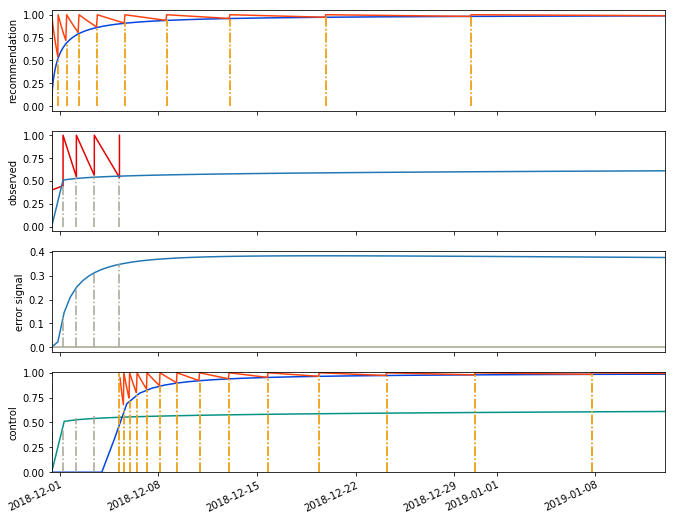

In [4]:
start_time    = datetime.now()
x, y          = feedback()
range_in_days = x[-1] * 1.5

# setting up our reference (goals)
hr = SpaceRepetitionReference(epoch=start_time,
                              range=range_in_days)

# what actually happened (feedback), range and epoch determined from hr
hf = SpaceRepetitionFeedback(x[0:5], y, range=range_in_days)

# giving our control system the reference and the feedback
hctrl = SpaceRepetitionController(reference=hr, feedback=hf)
# %timeit SpaceRepetitionController(reference=hr, feedback=hf)
data_dict = hctrl.plot_graphs()

## Queries about a future recollection
We have some nice graphs and we have a schedule, but let's say we want to ask spaced to predict something. For example, let's say we want to predict what the recollection numbers will be for the third forgetting curve of its control output.  Furthermore, to provide context about our query we would like to plot it on the control graph.  To do this, we could write this code:  

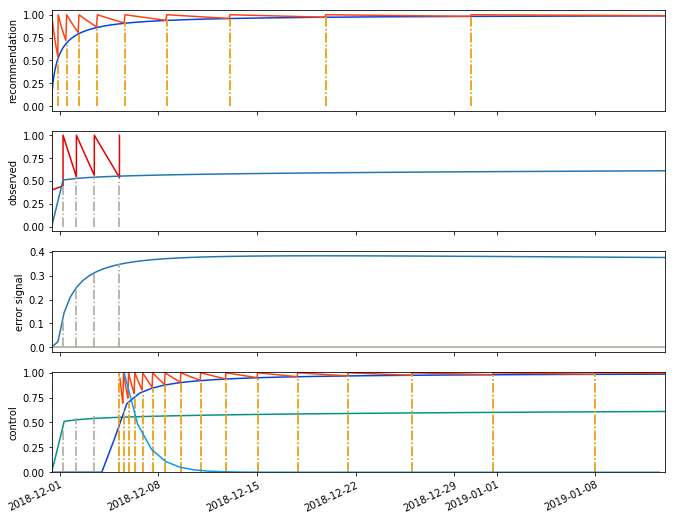

In [10]:
# plot the graph and get it's handle
graph_handle, _ = hctrl.plot_graphs()

# get a set of datetimes
useful_range_of_datetimes = hctrl.range_for(curve=2, range=10)

# make a results query using these datetime
results = [hctrl.recollect_scalar(moment, curve=2) for moment in useful_range_of_datetimes]

# control plot
control_plot = graph_handle.axarr[-1]
_ = control_plot.plot(useful_range_of_datetimes, results, color='xkcd:azure')




>  The predicted curve does not line up with the stickleback curve because there is a bug with the stickleback graphing code.  This will be fixed soon enough.  The falling blue curve is the accurate line.

Realistically speaking, we don't care about any forgetting curve that isn't the first curve.  So, let's plot its data onto the control graph:


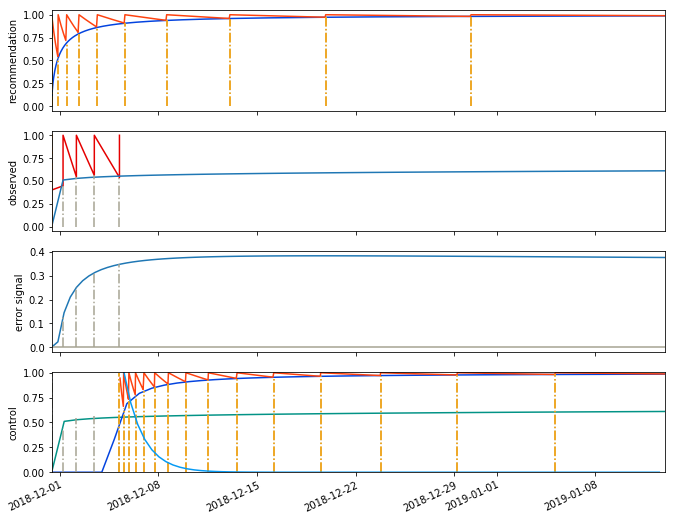

In [6]:
# plot the graph and get it's handle
graph_handle, data_dict = hctrl.plot_graphs()

curve = 2
# get a set of datetimes
useful_range_of_datetimes = hctrl.range_for(curve=curve, range=10, day_step_size=0.5)
# make a results query using these datetime
results = [hctrl.recollect_scalar(moment, curve=curve) for moment in useful_range_of_datetimes]

# control plot
control_plot = graph_handle.axarr[-1]
_ = control_plot.plot(useful_range_of_datetimes, results, color='xkcd:azure')


Once we trust that the algorithm is working, we probably won't graph it's information anymore, we will ask it for its suggestion about the next lesson's ``datetime`` schedule:


In [15]:
hctrl.next_lesson()

datetime.datetime(2018, 12, 5, 5, 41, 20, 666006)

If we use spaced within another library, we may want to ask it what the learning score will be for this particular thing that is being studied at a specific ``datetime``:


In [7]:
# find some future queury time that makes sense for our example
query_time = hctrl.datetime_for(curve=1) + timedelta(days=1.5)

# default's to the first forgetting curve
result = hctrl.recollect_scalar(query_time)
print(result)

0.133066445509816


## Getting a gut feel about what is going on
There are a lot of things that will affect a student's recollection of an idea.  Did they study?  Is our lesson approach sticky (plasticity)? How are the forgetting curves changing over time?  Given that there is a control system at play, is it appropriately tuned?  We would like to see a report card on this one thing; this report card will describe the relationship between our training and the student's work and when they worked.

To provide such information we can make a movie of the space algorithm's reaction to what happened in the world.  If you understand what the graphs mean, then you will be able to watch the video and infer if the model is wrong, if the student is studying and possibly other things.



In [8]:
%%HTML
<video height="600" controls>
  <source src="example.mp4" type="video/mp4">
</video>


As you play the video, you see a story unfold about the relationship between our model and the student's reaction to it.  In the first five days of their training, we see that they made more mistakes than we would have liked, then, around the seventh day, something clicks for them, and they do better than the original model expect them to do.  We can see that the control system tried to get them to do much more training when they were doing poorly, and less training when they started to understand the material.

The video plays a training event every second, which means that we are accelerating time since the training events become more and more spaced out the later they occur.

To generate your own animation:

### from datetime import datetime


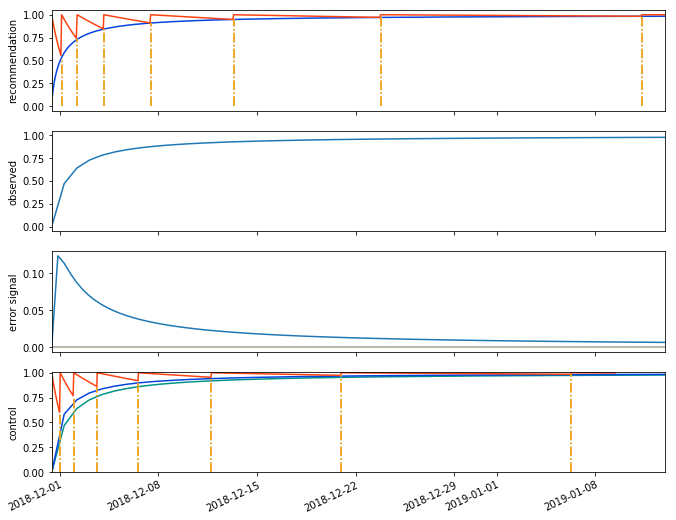

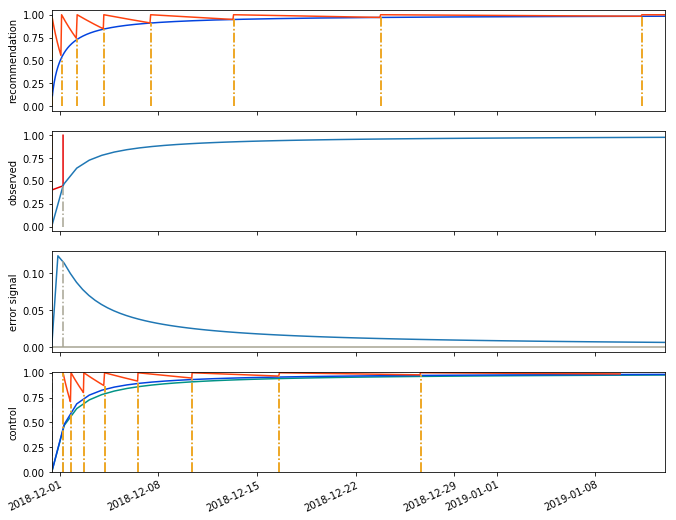

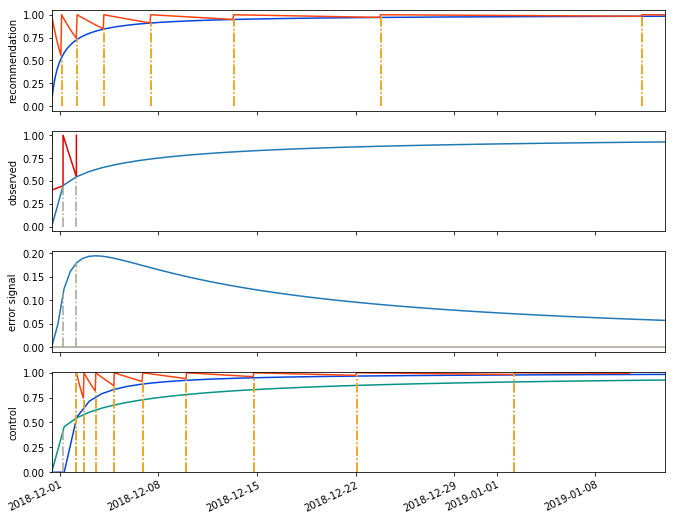

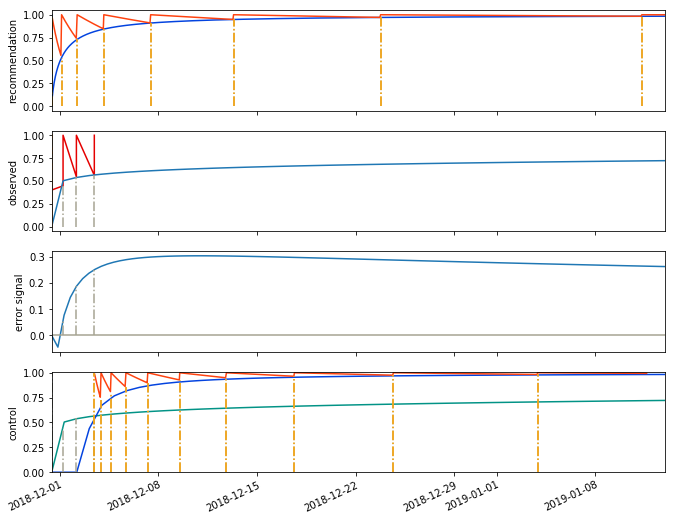

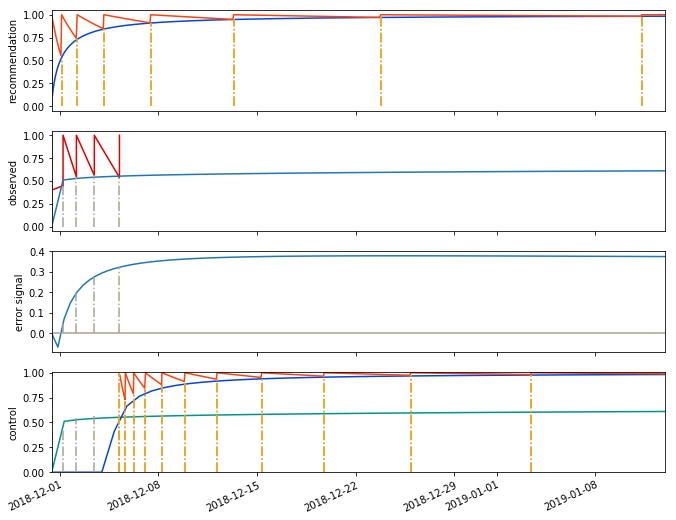

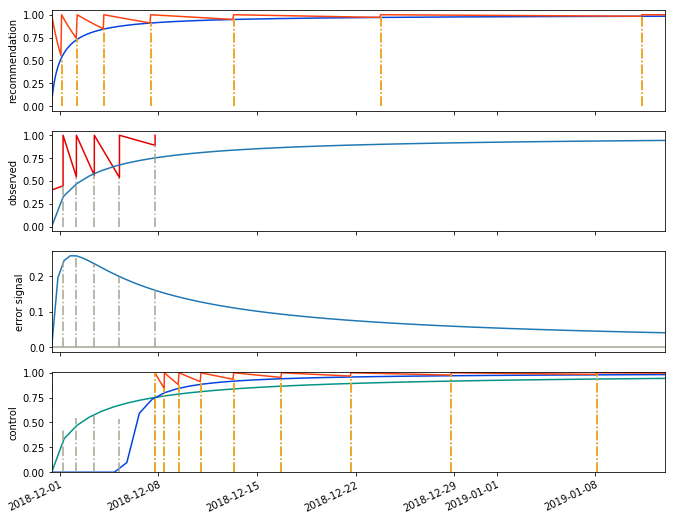

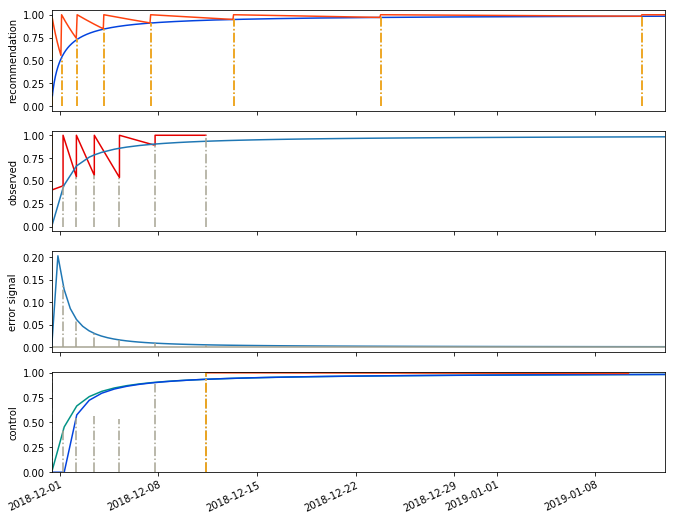

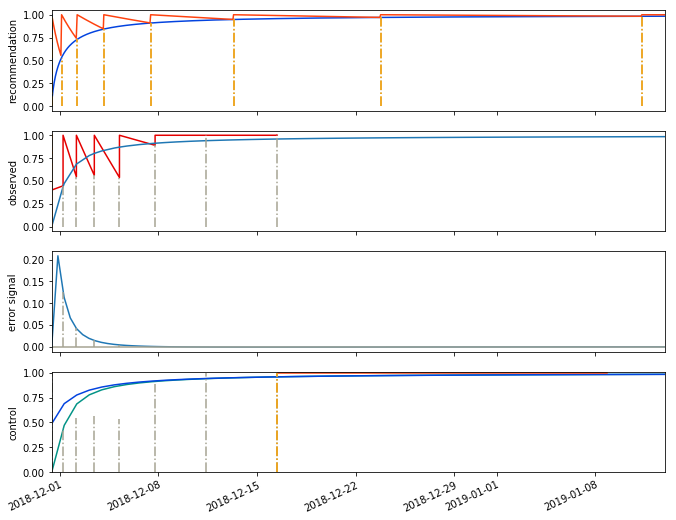

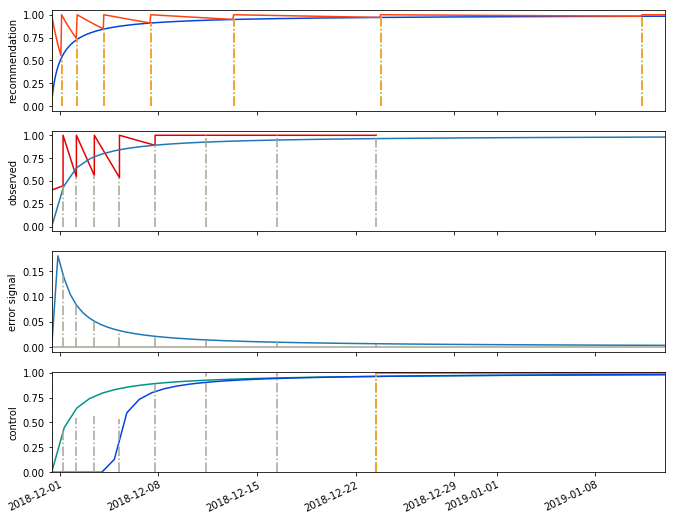

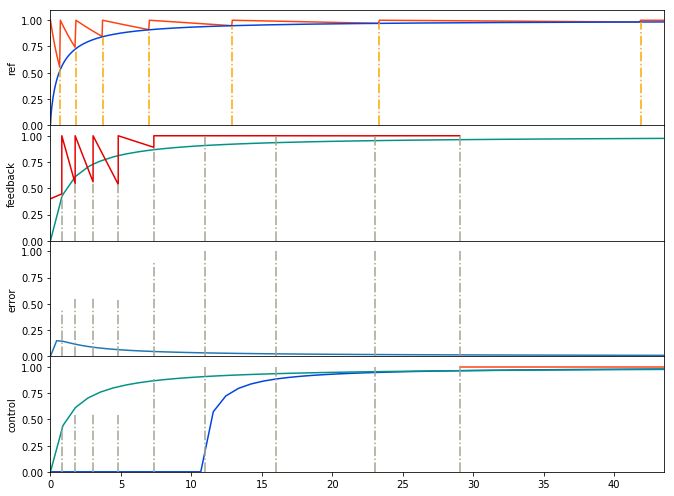

In [9]:
from spaced_repetition import LearningTracker

epoch = datetime.now()
lt = LearningTracker(
  epoch=epoch, 
  feedback_data=feedback(),
  plasticity=1.4,
  fdecaytau=0.87,
  fdecay0=0.9
)

lt.animate(
  student="Marnie MacMillan",
  name_of_mp4="report_card.mp4",
  time_per_event_in_seconds=2.2,
)

